# Data preprocessing

## emotion label + path to file

In [1]:
import pandas as pd
import numpy as np
import os

np.random.seed(646)

pathToData="../data/tess/"
imgsPath="../imgs/tess_hp_opt/"
modelsPath="../models/tess_hp_opt/"

def load_data(path):
    emotion, file_path = [], []
    
    # iterate over audio files extracting emotion label, file path and speaker info
    for root, _, files in os.walk(path):
        if len(files): # extract info only if files are found
            for filename in files:
                if filename.split('.')[1] == 'wav':
                    emotion.append(filename.split("_")[2].split(".")[0])
                    file_path.append(os.path.join(root, filename))
                
    # prepare dataframe
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({"ps": "surprised"})
    
    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(pathToData)
df

,path,emotion
0,../data/tess/oaf/OAF_pike_sad.wav,sad
1,../data/tess/oaf/OAF_bought_disgust.wav,disgust
2,../data/tess/oaf/OAF_gin_sad.wav,sad
3,../data/tess/oaf/OAF_learn_angry.wav,angry
4,../data/tess/oaf/OAF_moon_neutral.wav,neutral
...,...,...
2795,../data/tess/yaf/YAF_cause_fear.wav,fear
2796,../data/tess/yaf/YAF_hate_ps.wav,surprised
2797,../data/tess/yaf/YAF_gun_happy.wav,happy
2798,../data/tess/yaf/YAF_chair_disgust.wav,disgust


# Plots

## class distribution

['sad' 'disgust' 'angry' 'neutral' 'fear' 'happy' 'surprised']


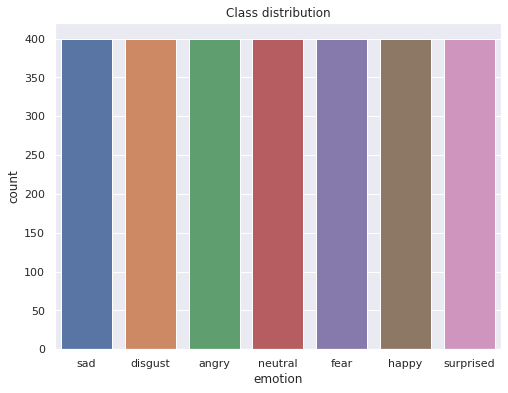

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
print(df['emotion'].unique())
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8,6))
sns.countplot(x = 'emotion', data = df)
plt.title('Class distribution')
plt.savefig(imgsPath + 'class_distribution.png')
plt.show()

## waveform

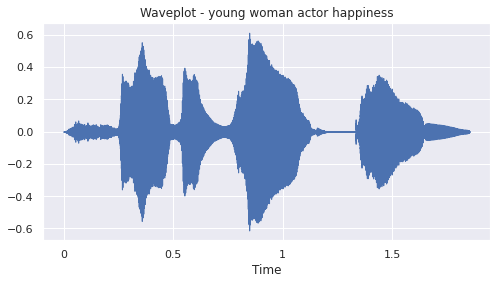

In [3]:
import librosa.display

# waveplot
wavf, sr = librosa.load('../data/tess/yaf/YAF_gun_happy.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - young woman actor happiness')
plt.savefig(imgsPath + 'waveplot_yaf_happiness.png')
plt.show()

## log-mel spectrogram

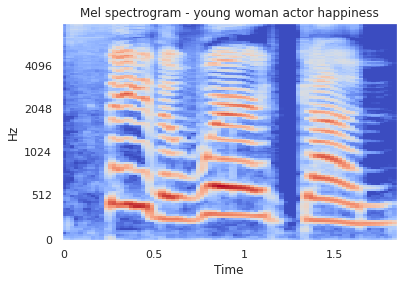

In [4]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - young woman actor happiness')
plt.savefig(imgsPath + 'mel_spec_yaf_happiness.png')
plt.show()

# Feature extraction

- [mfcc extraction info](https://www.researchgate.net/profile/Teddy-Gunawan/publication/353296706_Speech_Emotion_Recognition_Using_Feature_Fusion_of_TEO_and_MFCC_on_Multilingual_Databases/links/613ef96f4e1df2710631ca0a/Speech-Emotion-Recognition-Using-Feature-Fusion-of-TEO-and-MFCC-on-Multilingual-Databases.pdf)
- [librosa docs](https://librosa.org/doc/latest/index.html)

In [5]:
import librosa

# log-mel spectrogram into mfcc

logMelSpecVal = []

def parse_audio_file(pathToFile, _duration, sampleRate):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type="kaiser_fast", duration=_duration, sr=sampleRate)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 2, 44100)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,163,164,165,166,167,168,169,170,171,172
0,sad,-44.866684,-42.563484,-42.934090,-42.198429,-38.585060,-37.314648,-39.344276,-39.559017,-38.614834,...,-41.979794,-38.103256,-35.165031,-30.712734,-25.250000,-21.929203,-19.830929,-19.868361,-22.233919,-21.251535
1,disgust,-41.202820,-38.517208,-37.521523,-35.928848,-36.701500,-37.414253,-36.393902,-33.882385,-32.767769,...,-20.967327,-22.963118,-22.885572,-22.221870,-23.507053,-24.068279,-25.479784,-24.551914,-20.904539,-16.470636
2,sad,-44.523106,-41.317688,-38.223133,-37.148476,-35.793209,-36.431770,-35.850277,-36.279404,-36.554703,...,-37.707291,-39.314594,-38.339470,-38.279835,-38.296024,-39.444401,-39.700020,-40.861137,-39.896214,-38.872395
3,angry,-41.129044,-41.145790,-40.203060,-40.004387,-39.338234,-38.796188,-36.842579,-37.031277,-36.232571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,neutral,-43.564331,-43.538578,-43.997803,-43.378044,-42.618168,-40.774433,-39.563217,-39.384590,-41.079617,...,-26.839230,-26.929281,-27.145792,-26.891811,-26.995079,-26.535362,-26.693199,-27.490786,-23.562895,-18.484276


# Data split

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def data_split(df):
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    # stratified train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

            0          1          2          3          4          5    \
1957 -36.305271 -36.789738 -36.425220 -34.747608 -35.367222 -36.745964   
1105 -40.173527 -41.522141 -42.365028 -39.217091 -35.474632 -35.014355   
254  -43.793388 -43.241306 -43.019321 -41.574070 -40.106453 -35.029846   
2592 -32.160595 -29.258410 -23.278524 -22.255568 -26.362617 -29.601513   
1179 -31.665293 -35.141491 -42.677780 -44.319191 -46.104473 -45.569675   

            6          7          8          9    ...        163        164  \
1957 -36.117542 -36.514889 -36.810520 -36.554073  ... -36.101200 -39.634762   
1105 -34.125809 -33.744308 -32.054882 -32.173038  ...   0.000000   0.000000   
254  -33.976143 -34.539223 -33.108162 -34.407253  ... -46.415386 -39.463905   
2592 -29.792355 -33.346142 -32.624657 -30.397259  ... -27.827576 -29.221291   
1179 -42.089725 -39.481453 -39.381378 -37.650951  ... -26.674839 -26.402981   

            165        166        167        168        169        170  \
1957  

# Data preparation and normalization

In [7]:
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

2022-05-27 12:29:17.416143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


(2240,)
(560,)
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprised']
(2240, 173, 1)


# Model architecture

- [model architecture info](https://www.researchgate.net/profile/Gregor-Hofer-3/publication/335829168_Analysis_of_Deep_Learning_Architectures_for_Cross-Corpus_Speech_Emotion_Recognition/links/5e2f0a2f4585152d156d9f4f/Analysis-of-Deep-Learning-Architectures-for-Cross-Corpus-Speech-Emotion-Recognition.pdf)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.utils import plot_model

# model initialization
def get_model(hidden_layers_count = 3, layers_neurons_count = [64, 128, 128, 256], activation_function = 'relu',
             output_activation_function = 'sigmoid', conv_kernel_size = 10, pooling_pool_size = 8,
              loss_function = 'categorical_crossentropy', opt = keras.optimizers.Adam(learning_rate=0.001),
             dropout_rate = 0.4):
    
    model = tf.keras.Sequential()
    
    # input layer
    model.add(layers.Conv1D(layers_neurons_count[0], kernel_size = conv_kernel_size, activation = activation_function,
                           input_shape = (X_train.shape[1], 1)))
    
    # hidden layers
    for i in range(1, hidden_layers_count):
        model.add(layers.Conv1D(layers_neurons_count[i], kernel_size=conv_kernel_size,
                               activation=activation_function))
        model.add(layers.MaxPooling1D(pool_size=pooling_pool_size))
        model.add(layers.Dropout(dropout_rate))
        
    # fully connected layer
    model.add(layers.Flatten())
    model.add(layers.Dense(layers_neurons_count[-1], activation=activation_function))
    model.add(layers.Dropout(dropout_rate))
    
    # output layer
    model.add(layers.Dense(7, activation=output_activation_function))
    
    # loss function and optimizer
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])
    
    return model

# Model training and export

In [9]:
from keras.callbacks import ModelCheckpoint

def fit_save_results(model, custom_model_name = 'default_model', paths = [modelsPath, imgsPath],
                    batch_size = 32, epochs = 40):
    
    # new dir prep
    for p in paths:
        os.makedirs(os.path.join(p, custom_model_name), exist_ok=True)
    
    # use checkpoints to save best model
    checkpoint = ModelCheckpoint(os.path.join(paths[0], custom_model_name), monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')

    # fit model
    model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),
                              callbacks=[checkpoint], verbose=0)

    # plot model accuracy and loss over epochs
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(os.path.join(paths[1], custom_model_name, f'{custom_model_name}_accuracy.png'))
    plt.show()

    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(os.path.join(paths[1], custom_model_name, f'{custom_model_name}_loss.png'))
    plt.show()
    
    # loss and accuracy percentage on test set
    with open(os.path.join(paths[0], custom_model_name, f'{custom_model_name}_res.txt'), 'w') as f:
        f.write(f"Loss of the model is - {model.evaluate(X_test,y_test)[0]}")
        f.write(f"Accuracy of the model is - {model.evaluate(X_test,y_test)[1]*100}%")
    
    return

# Hyperparameter tuning

## Architecture (layers, neurons count)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 164, 64)           704       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 155, 512)          328192    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 512)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1245312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

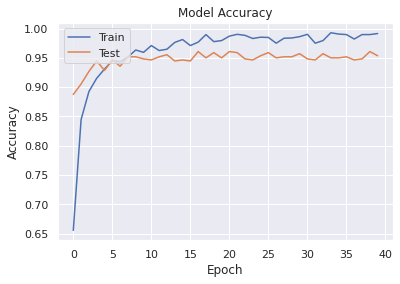

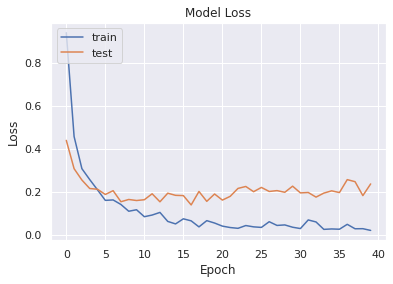

18/18 [==============================] - 0s 3ms/step - loss: 0.2370 - accuracy: 0.9536
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 164, 173)          1903      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 155, 512)          886272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 19, 512)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               4981248   
_________________________________

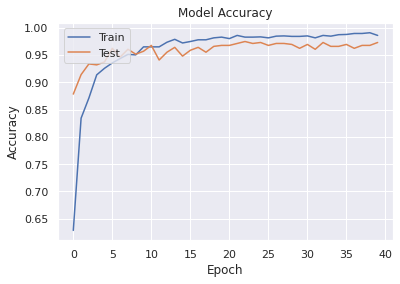

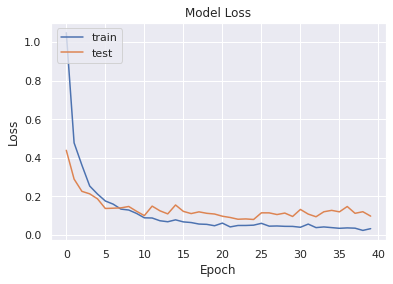

18/18 [==============================] - 0s 4ms/step - loss: 0.0979 - accuracy: 0.9732
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 164, 64)           704       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 155, 128)          82048     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 10, 128)           163968    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1, 128)            0         
_________________________________

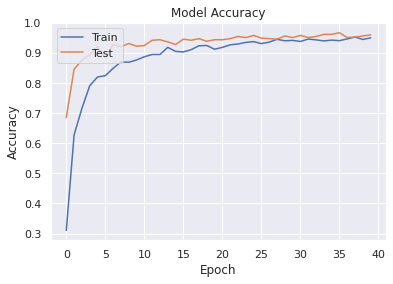

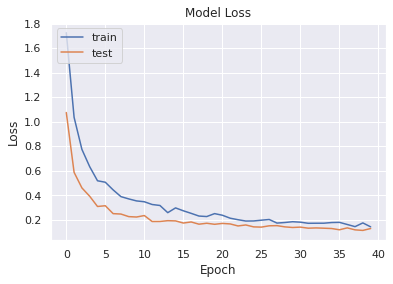

18/18 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.9607
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 164, 82)           902       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 155, 64)           52544     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 19, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 10, 64)            41024     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 1, 64)             0         
_________________________________

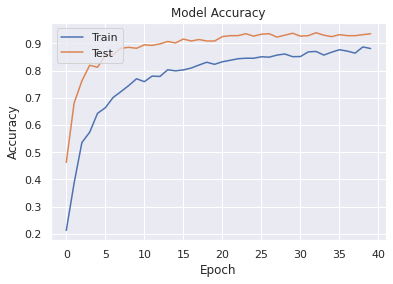

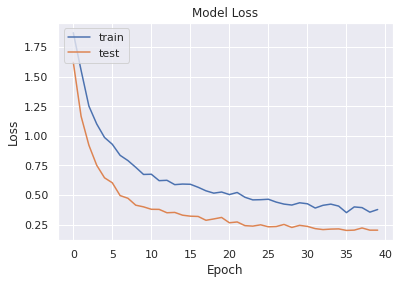

18/18 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.9357
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 171, 82)           328       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 169, 100)          24700     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 56, 100)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 56, 100)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 54, 100)           30100     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 18, 100)           0         
_________________________________


Epoch 00031: val_accuracy did not improve from 0.88750

Epoch 00032: val_accuracy did not improve from 0.88750

Epoch 00033: val_accuracy did not improve from 0.88750

Epoch 00034: val_accuracy did not improve from 0.88750

Epoch 00035: val_accuracy did not improve from 0.88750

Epoch 00036: val_accuracy did not improve from 0.88750

Epoch 00037: val_accuracy improved from 0.88750 to 0.89286, saving model to ../models/tess_hp_opt/82_100_100_200_100_50_kern_3_pool_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/82_100_100_200_100_50_kern_3_pool_3_model/assets

Epoch 00038: val_accuracy did not improve from 0.89286

Epoch 00039: val_accuracy did not improve from 0.89286

Epoch 00040: val_accuracy did not improve from 0.89286


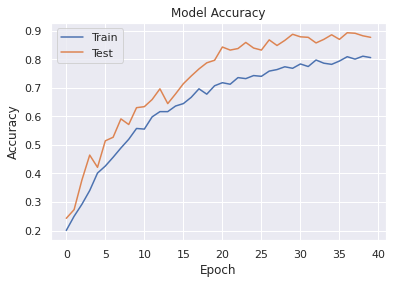

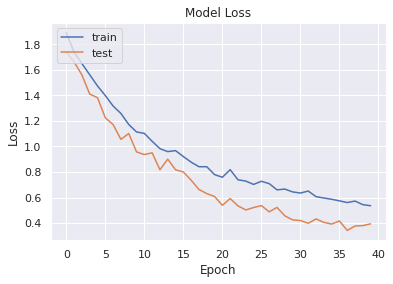

18/18 [==============================] - 0s 2ms/step - loss: 0.3939 - accuracy: 0.8768


In [13]:
best_params = {}

proposed_architectures = (
    [2, [64, 512, 128]],
    [2, [173, 512, 512]],
    [3, [64, 128, 128, 256]],
    [3, [82, 64, 64, 32]]
)

for arch in proposed_architectures:
    model = get_model(arch[0], arch[1])
    model.summary()
    fit_save_results(model, custom_model_name=f'{str(arch[1]).replace(" ", "_")}_model')
    
model = get_model(5, [82, 100, 100, 200, 100, 50], conv_kernel_size=3, pooling_pool_size=3)
model.summary()
fit_save_results(model, custom_model_name='82_100_100_200_100_50_kern_3_pool_3_model')


## Activation function

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 164, 173)          1903      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 155, 512)          886272    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 19, 512)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               4981248   
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)              

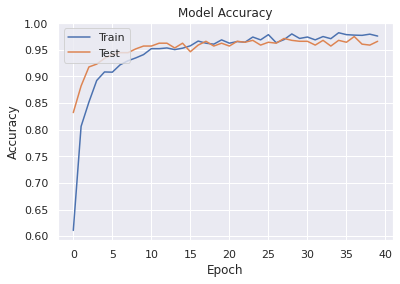

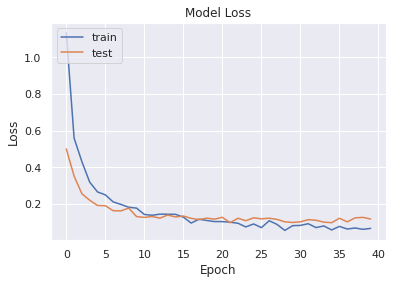

18/18 [==============================] - 0s 5ms/step - loss: 0.1171 - accuracy: 0.9661
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 164, 173)          1903      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 155, 512)          886272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 19, 512)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               4981248   
_________________________________

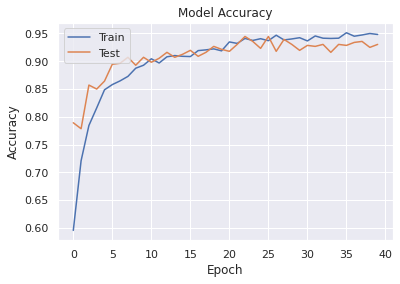

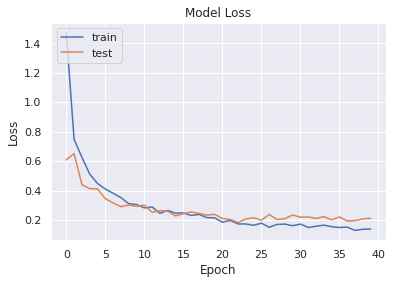

18/18 [==============================] - 0s 4ms/step - loss: 0.2115 - accuracy: 0.9304
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 164, 173)          1903      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 155, 512)          886272    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 19, 512)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               4981248   
_________________________________

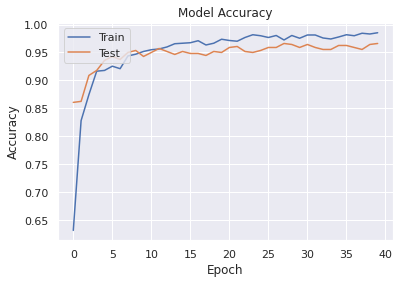

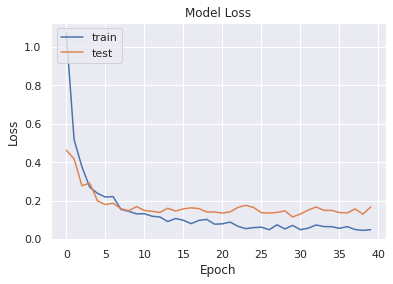

18/18 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.9661
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 164, 173)          1903      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 155, 512)          886272    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 19, 512)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9728)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               4981248   
_________________________________

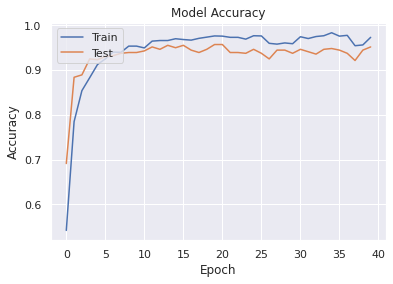

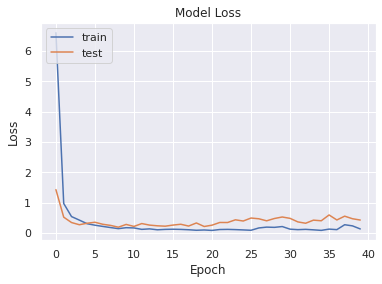

18/18 [==============================] - 0s 5ms/step - loss: 0.4239 - accuracy: 0.9518


In [12]:
# best topology
best_params['hlayers'] = 2
best_params['neurons'] = (173, 512, 512)

activation_functions = (
    {'act_fun': 'relu', 'out_act_fun': 'sigmoid'},
    {'act_fun': 'tanh', 'out_act_fun': 'softmax'},
    {'act_fun': 'relu', 'out_act_fun': 'softmax'},
    {'act_fun': 'selu', 'out_act_fun': 'sigmoid'},
)

for act in activation_functions:
    model = get_model(hidden_layers_count=best_params[0], layers_neurons_count=best_params[1],
                      activation_function=act['act_fun'],
                      output_activation_function=act['out_act_fun'])
    fit_save_results(model,
                     custom_model_name=f'act_fun_{act["act_fun"]}_out_act_fun_{act["out_act_fun"]}_model')
    

## Conv parameters (kernel size, pool size)

new model test

Epoch 00001: val_accuracy improved from -inf to 0.83929, saving model to ../models/tess_hp_opt/10_8_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/10_8_model/assets

Epoch 00002: val_accuracy improved from 0.83929 to 0.92143, saving model to ../models/tess_hp_opt/10_8_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/10_8_model/assets

Epoch 00003: val_accuracy did not improve from 0.92143

Epoch 00004: val_accuracy improved from 0.92143 to 0.93571, saving model to ../models/tess_hp_opt/10_8_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/10_8_model/assets

Epoch 00005: val_accuracy improved from 0.93571 to 0.94286, saving model to ../models/tess_hp_opt/10_8_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/10_8_model/assets

Epoch 00006: val_accuracy improved from 0.94286 to 0.94643, saving model to ../models/tess_hp_opt/10_8_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/10_8_model/assets

Epoch 

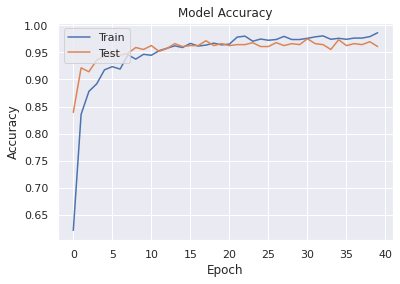

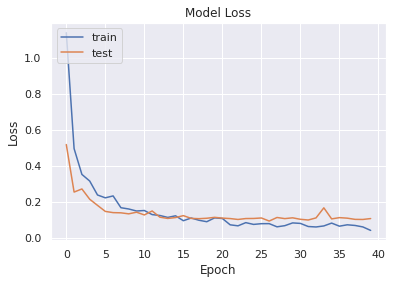

18/18 [==============================] - 0s 4ms/step - loss: 0.1057 - accuracy: 0.9607
new model test


2022-05-25 18:08:28.789442: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-25 18:08:28.829280: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_accuracy improved from -inf to 0.86250, saving model to ../models/tess_hp_opt/3_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/3_3_model/assets

Epoch 00002: val_accuracy improved from 0.86250 to 0.86964, saving model to ../models/tess_hp_opt/3_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/3_3_model/assets

Epoch 00003: val_accuracy improved from 0.86964 to 0.92321, saving model to ../models/tess_hp_opt/3_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/3_3_model/assets

Epoch 00004: val_accuracy did not improve from 0.92321

Epoch 00005: val_accuracy did not improve from 0.92321

Epoch 00006: val_accuracy improved from 0.92321 to 0.92679, saving model to ../models/tess_hp_opt/3_3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/3_3_model/assets

Epoch 00007: val_accuracy improved from 0.92679 to 0.93036, saving model to ../models/tess_hp_opt/3_3_model
INFO:tensorflow:Assets written to: ../models/tess_

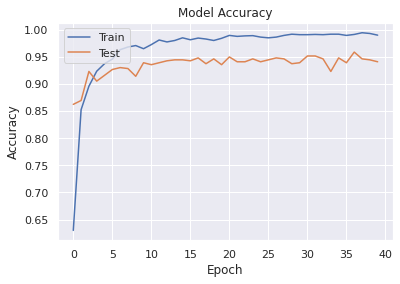

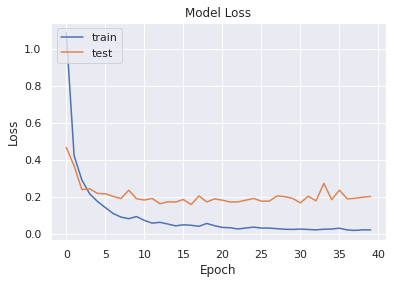

18/18 [==============================] - 0s 4ms/step - loss: 0.2028 - accuracy: 0.9411
new model test


2022-05-25 18:09:19.956564: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-25 18:09:20.000450: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_accuracy improved from -inf to 0.86964, saving model to ../models/tess_hp_opt/5_7_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/5_7_model/assets

Epoch 00002: val_accuracy improved from 0.86964 to 0.87679, saving model to ../models/tess_hp_opt/5_7_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/5_7_model/assets

Epoch 00003: val_accuracy improved from 0.87679 to 0.93214, saving model to ../models/tess_hp_opt/5_7_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/5_7_model/assets

Epoch 00004: val_accuracy improved from 0.93214 to 0.93750, saving model to ../models/tess_hp_opt/5_7_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/5_7_model/assets

Epoch 00005: val_accuracy improved from 0.93750 to 0.94821, saving model to ../models/tess_hp_opt/5_7_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/5_7_model/assets

Epoch 00006: val_accuracy improved from 0.94821 to 0.95179, saving model to ../models/t

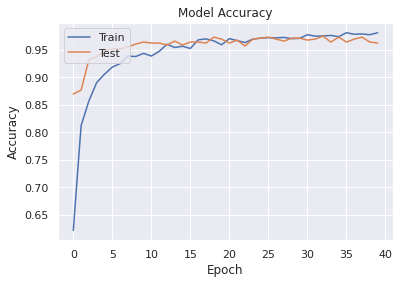

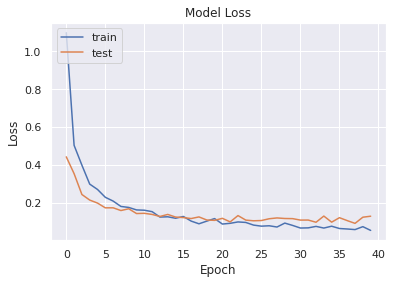

18/18 [==============================] - 0s 4ms/step - loss: 0.1282 - accuracy: 0.9625
new model test

Epoch 00001: val_accuracy improved from -inf to 0.87679, saving model to ../models/tess_hp_opt/6_4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/6_4_model/assets

Epoch 00002: val_accuracy improved from 0.87679 to 0.92143, saving model to ../models/tess_hp_opt/6_4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/6_4_model/assets

Epoch 00003: val_accuracy improved from 0.92143 to 0.92500, saving model to ../models/tess_hp_opt/6_4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/6_4_model/assets

Epoch 00004: val_accuracy improved from 0.92500 to 0.93393, saving model to ../models/tess_hp_opt/6_4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/6_4_model/assets

Epoch 00005: val_accuracy improved from 0.93393 to 0.95000, saving model to ../models/tess_hp_opt/6_4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/6_4

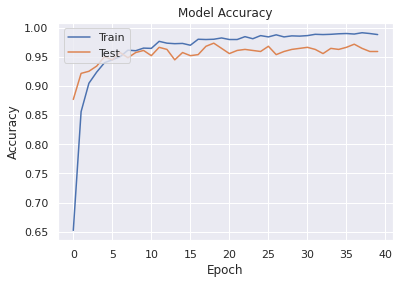

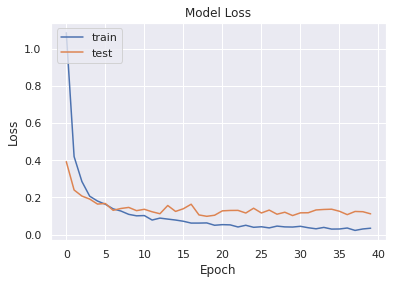

18/18 [==============================] - 0s 4ms/step - loss: 0.1121 - accuracy: 0.9589


In [22]:
# best activation funs
best_params['act_fun'] = 'relu'
best_params['out_act_fun'] = 'sigmoid'

conv_parameters = (
    {'kern_size': 10, 'pool_size': 8},
    {'kern_size': 3, 'pool_size': 3},
    {'kern_size': 5, 'pool_size': 7},
    {'kern_size': 6, 'pool_size': 4}
)

for params in conv_parameters:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=params['kern_size'], pooling_pool_size=params['pool_size'])
    fit_save_results(model,
                     custom_model_name=f'kern_size_{params["kern_size"]}_pool_size_{params["pool_size"]}_model')
    

## Optimizer and learning rate

2022-05-25 18:34:00.824062: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-25 18:34:00.825095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-25 18:34:00.871684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 18:34:00.872047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-05-25 18:34:00.872081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-25 18:34:00.873119: I tensorflow/stream_executor/platfor

new model test


2022-05-25 18:34:01.525801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-25 18:34:01.619530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-25 18:34:02.017274: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-25 18:34:02.073337: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_accuracy improved from -inf to 0.89286, saving model to ../models/tess_hp_opt/opt_adam_model


2022-05-25 18:34:03.531453: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00002: val_accuracy improved from 0.89286 to 0.90714, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00003: val_accuracy improved from 0.90714 to 0.91250, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00004: val_accuracy improved from 0.91250 to 0.93393, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00005: val_accuracy improved from 0.93393 to 0.94643, saving model to ../models/tess_hp_opt/opt_adam_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adam_model/assets

Epoch 00006: val_accuracy did not improve from 0.94643

Epoch 00007: val_accuracy did not improve from 0.94643

Epoch 00008: val_accuracy improved f

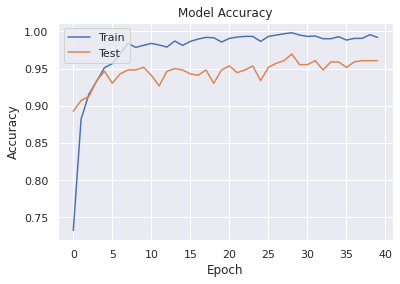

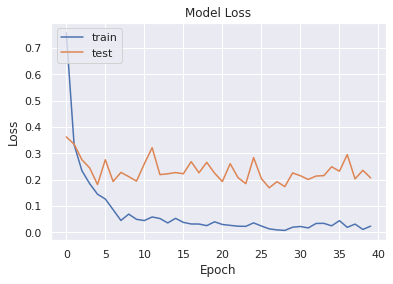

18/18 [==============================] - 0s 4ms/step - loss: 0.2064 - accuracy: 0.9607
new model test

Epoch 00001: val_accuracy improved from -inf to 0.53750, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00002: val_accuracy improved from 0.53750 to 0.67143, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00003: val_accuracy improved from 0.67143 to 0.71429, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00004: val_accuracy improved from 0.71429 to 0.73929, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_sgd_model/assets

Epoch 00005: val_accuracy improved from 0.73929 to 0.77321, saving model to ../models/tess_hp_opt/opt_sgd_model
INFO:tensorflow:Assets w

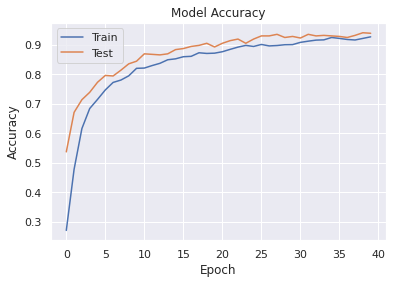

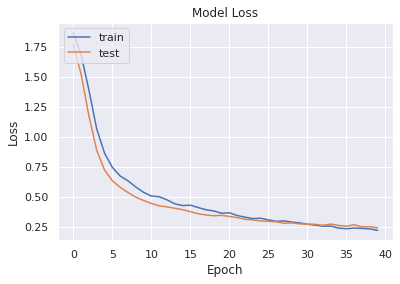

18/18 [==============================] - 0s 4ms/step - loss: 0.2406 - accuracy: 0.9393
new model test

Epoch 00001: val_accuracy improved from -inf to 0.78929, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00002: val_accuracy did not improve from 0.78929

Epoch 00003: val_accuracy improved from 0.78929 to 0.88929, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00004: val_accuracy improved from 0.88929 to 0.90714, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00005: val_accuracy improved from 0.90714 to 0.91250, saving model to ../models/tess_hp_opt/opt_rmsprop_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_rmsprop_model/assets

Epoch 00006: val_accuracy did not improve from 0

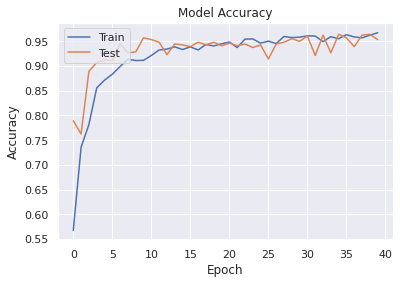

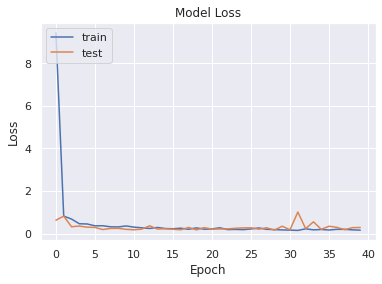

18/18 [==============================] - 0s 4ms/step - loss: 0.2903 - accuracy: 0.9536
new model test

Epoch 00001: val_accuracy improved from -inf to 0.54286, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00002: val_accuracy improved from 0.54286 to 0.69643, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00003: val_accuracy improved from 0.69643 to 0.76607, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00004: val_accuracy improved from 0.76607 to 0.81250, saving model to ../models/tess_hp_opt/opt_adagrad_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/opt_adagrad_model/assets

Epoch 00005: val_accuracy improved from 0.81250 to 0.81607, saving model to ../models/tess_hp_opt/opt_ad

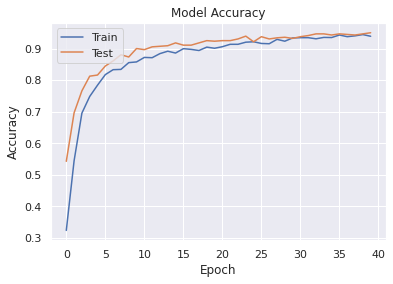

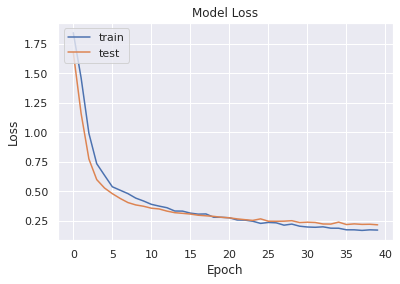

18/18 [==============================] - 0s 4ms/step - loss: 0.2156 - accuracy: 0.9500


In [11]:
# best conv params
best_params['kern_size'] = 5
best_params['pool_size'] = 7

optimizer_loss_params = (
    {'opt_name': 'adam', 'opt': keras.optimizers.Adam(learning_rate=0.001)},
    {'opt_name': 'sgd', 'opt': keras.optimizers.SGD(learning_rate=0.005)},
    {'opt_name': 'rmsprop', 'opt': keras.optimizers.RMSprop(learning_rate=0.009)},
    {'opt_name': 'adagrad', 'opt': keras.optimizers.Adagrad(learning_rate=0.003)}
)

for params in optimizer_loss_params:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                     opt=params['opt'])
    fit_save_results(model,
                     custom_model_name=f'opt_{params["opt_name"]}_model')
    

## Batch size and number of epochs

2022-05-25 19:39:03.554323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-25 19:39:03.578293: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz
2022-05-25 19:39:03.877950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-25 19:39:04.279213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-05-25 19:39:05.719783: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-25 19:39:05.796186: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to alloc


Epoch 00001: val_accuracy improved from -inf to 0.51607, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model


2022-05-25 19:39:07.149368: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00002: val_accuracy improved from 0.51607 to 0.64464, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00003: val_accuracy improved from 0.64464 to 0.75714, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00004: val_accuracy improved from 0.75714 to 0.81250, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00005: val_accuracy improved from 0.81250 to 0.83214, saving model to ../models/tess_hp_opt/batch_size_32_epochs_40_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_32_epochs_40_model/assets

Epoch 00006: 

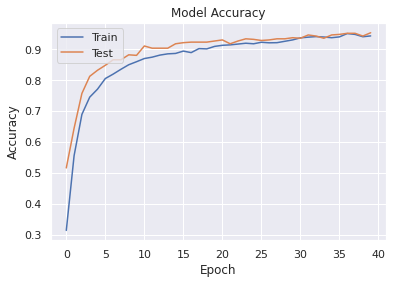

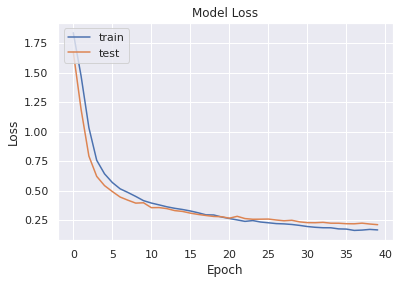

18/18 [==============================] - 0s 4ms/step - loss: 0.2105 - accuracy: 0.9536


2022-05-25 19:39:53.828381: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-25 19:39:53.888805: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_accuracy improved from -inf to 0.31071, saving model to ../models/tess_hp_opt/batch_size_100_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_100_epochs_80_model/assets

Epoch 00002: val_accuracy improved from 0.31071 to 0.41607, saving model to ../models/tess_hp_opt/batch_size_100_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_100_epochs_80_model/assets

Epoch 00003: val_accuracy improved from 0.41607 to 0.48036, saving model to ../models/tess_hp_opt/batch_size_100_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_100_epochs_80_model/assets

Epoch 00004: val_accuracy improved from 0.48036 to 0.55179, saving model to ../models/tess_hp_opt/batch_size_100_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_100_epochs_80_model/assets

Epoch 00005: val_accuracy improved from 0.55179 to 0.62857, saving model to ../models/tess_hp_opt/batc


Epoch 00060: val_accuracy did not improve from 0.93036

Epoch 00061: val_accuracy improved from 0.93036 to 0.93393, saving model to ../models/tess_hp_opt/batch_size_100_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_100_epochs_80_model/assets

Epoch 00062: val_accuracy did not improve from 0.93393

Epoch 00063: val_accuracy did not improve from 0.93393

Epoch 00064: val_accuracy did not improve from 0.93393

Epoch 00065: val_accuracy did not improve from 0.93393

Epoch 00066: val_accuracy did not improve from 0.93393

Epoch 00067: val_accuracy did not improve from 0.93393

Epoch 00068: val_accuracy improved from 0.93393 to 0.93571, saving model to ../models/tess_hp_opt/batch_size_100_epochs_80_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_100_epochs_80_model/assets

Epoch 00069: val_accuracy did not improve from 0.93571

Epoch 00070: val_accuracy improved from 0.93571 to 0.93750, saving model to ../models/tess_hp_opt/bat

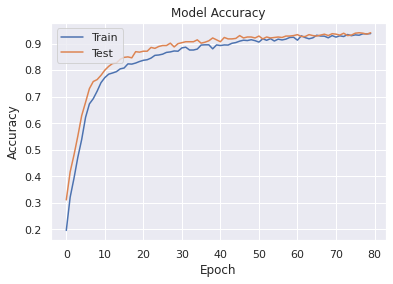

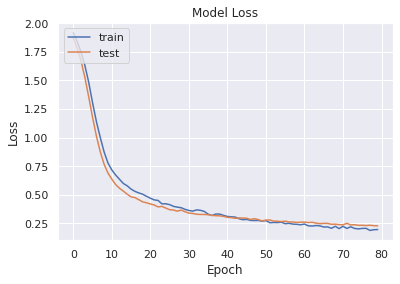

18/18 [==============================] - 0s 4ms/step - loss: 0.2289 - accuracy: 0.9411

Epoch 00001: val_accuracy improved from -inf to 0.49286, saving model to ../models/tess_hp_opt/batch_size_50_epochs_30_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_50_epochs_30_model/assets

Epoch 00002: val_accuracy improved from 0.49286 to 0.63929, saving model to ../models/tess_hp_opt/batch_size_50_epochs_30_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_50_epochs_30_model/assets

Epoch 00003: val_accuracy improved from 0.63929 to 0.69107, saving model to ../models/tess_hp_opt/batch_size_50_epochs_30_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_50_epochs_30_model/assets

Epoch 00004: val_accuracy improved from 0.69107 to 0.75714, saving model to ../models/tess_hp_opt/batch_size_50_epochs_30_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_50_epochs_30_model/assets

Epoch 00005: val_accura

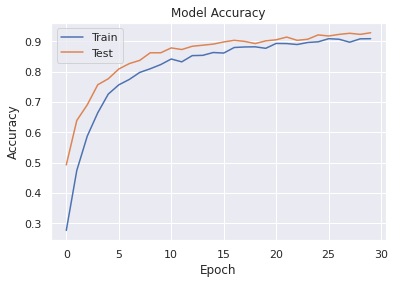

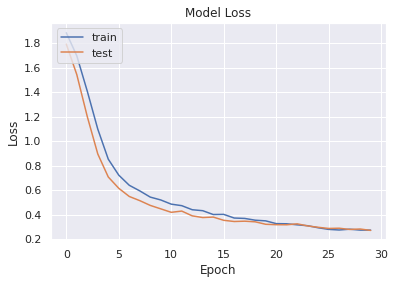

18/18 [==============================] - 0s 4ms/step - loss: 0.2704 - accuracy: 0.9286

Epoch 00001: val_accuracy improved from -inf to 0.69286, saving model to ../models/tess_hp_opt/batch_size_16_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_16_epochs_20_model/assets

Epoch 00002: val_accuracy improved from 0.69286 to 0.75714, saving model to ../models/tess_hp_opt/batch_size_16_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_16_epochs_20_model/assets

Epoch 00003: val_accuracy improved from 0.75714 to 0.85893, saving model to ../models/tess_hp_opt/batch_size_16_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_16_epochs_20_model/assets

Epoch 00004: val_accuracy improved from 0.85893 to 0.86964, saving model to ../models/tess_hp_opt/batch_size_16_epochs_20_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/batch_size_16_epochs_20_model/assets

Epoch 00005: val_accura

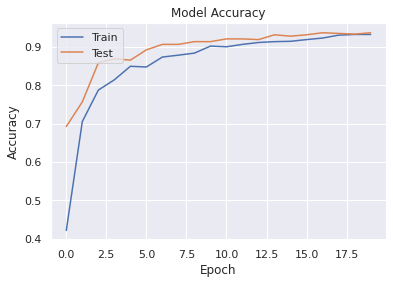

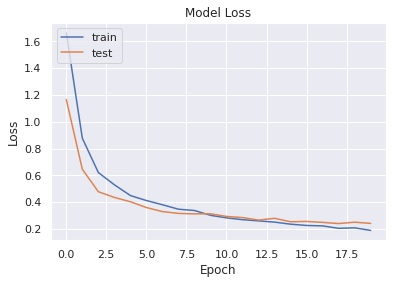

18/18 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9375


In [13]:
# best optimizer, learning rate params
best_params['opt'] = keras.optimizers.Adagrad(learning_rate=0.003)

optimizer_loss_params = (
    {'batch_size': 32, 'epochs': 40},
    {'batch_size': 100, 'epochs': 80},
    {'batch_size': 50, 'epochs': 30},
    {'batch_size': 16, 'epochs': 20}
)

for params in optimizer_loss_params:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                     opt=best_params['opt'])
    fit_save_results(model, batch_size=params['batch_size'], epochs=params['epochs'],
                    custom_model_name=f'batch_size_{params["batch_size"]}_epochs_{params["epochs"]}_model')
    

## Dropout rate


Epoch 00001: val_accuracy improved from -inf to 0.53393, saving model to ../models/tess_hp_opt/droput_rate_0.4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets

Epoch 00002: val_accuracy improved from 0.53393 to 0.66250, saving model to ../models/tess_hp_opt/droput_rate_0.4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets

Epoch 00003: val_accuracy improved from 0.66250 to 0.74821, saving model to ../models/tess_hp_opt/droput_rate_0.4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets

Epoch 00004: val_accuracy improved from 0.74821 to 0.80179, saving model to ../models/tess_hp_opt/droput_rate_0.4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.4_model/assets

Epoch 00005: val_accuracy improved from 0.80179 to 0.82857, saving model to ../models/tess_hp_opt/droput_rate_0.4_model
INFO:tensorflow:Assets written to: ../models/tess_hp_o

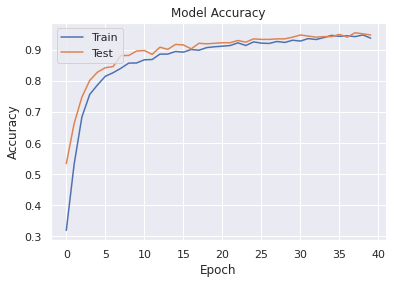

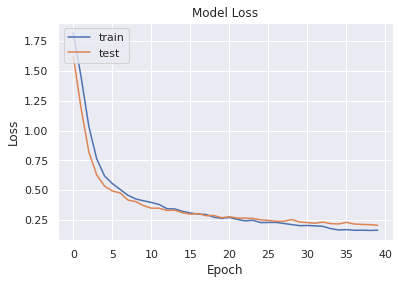

18/18 [==============================] - 0s 4ms/step - loss: 0.2052 - accuracy: 0.9482

Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to ../models/tess_hp_opt/droput_rate_0.3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets

Epoch 00002: val_accuracy improved from 0.60000 to 0.71250, saving model to ../models/tess_hp_opt/droput_rate_0.3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets

Epoch 00003: val_accuracy improved from 0.71250 to 0.77679, saving model to ../models/tess_hp_opt/droput_rate_0.3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets

Epoch 00004: val_accuracy improved from 0.77679 to 0.81429, saving model to ../models/tess_hp_opt/droput_rate_0.3_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.3_model/assets

Epoch 00005: val_accuracy improved from 0.81429 to 0.84643, saving model to ../models/t

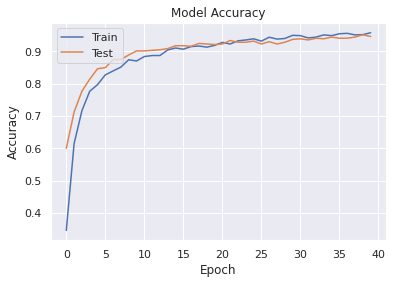

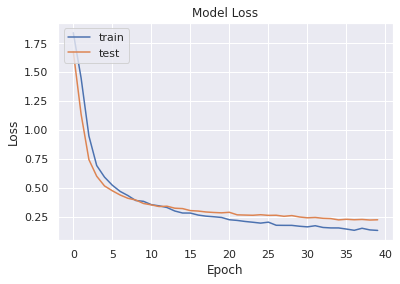

18/18 [==============================] - 0s 4ms/step - loss: 0.2216 - accuracy: 0.9464

Epoch 00001: val_accuracy improved from -inf to 0.55893, saving model to ../models/tess_hp_opt/droput_rate_0.2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets

Epoch 00002: val_accuracy improved from 0.55893 to 0.69107, saving model to ../models/tess_hp_opt/droput_rate_0.2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets

Epoch 00003: val_accuracy improved from 0.69107 to 0.78036, saving model to ../models/tess_hp_opt/droput_rate_0.2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets

Epoch 00004: val_accuracy improved from 0.78036 to 0.81964, saving model to ../models/tess_hp_opt/droput_rate_0.2_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.2_model/assets

Epoch 00005: val_accuracy improved from 0.81964 to 0.84643, saving model to ../models/t

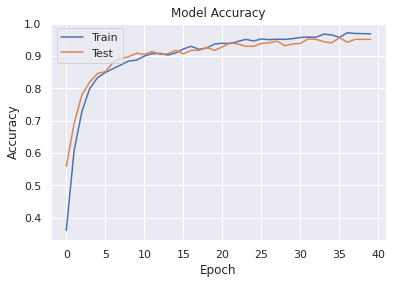

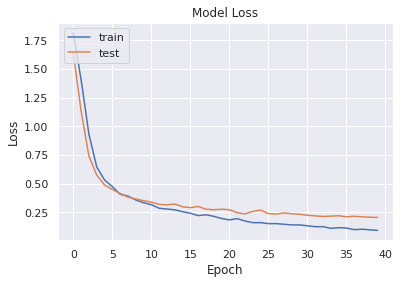

18/18 [==============================] - 0s 5ms/step - loss: 0.2059 - accuracy: 0.9518

Epoch 00001: val_accuracy improved from -inf to 0.67143, saving model to ../models/tess_hp_opt/droput_rate_0.1_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets

Epoch 00002: val_accuracy improved from 0.67143 to 0.72143, saving model to ../models/tess_hp_opt/droput_rate_0.1_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets

Epoch 00003: val_accuracy improved from 0.72143 to 0.79643, saving model to ../models/tess_hp_opt/droput_rate_0.1_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets

Epoch 00004: val_accuracy improved from 0.79643 to 0.83750, saving model to ../models/tess_hp_opt/droput_rate_0.1_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/droput_rate_0.1_model/assets

Epoch 00005: val_accuracy improved from 0.83750 to 0.85357, saving model to ../models/t

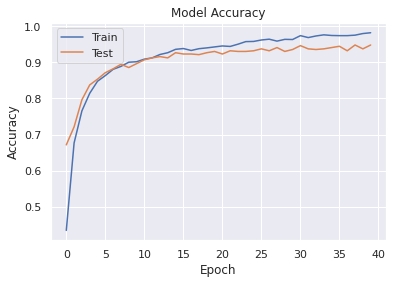

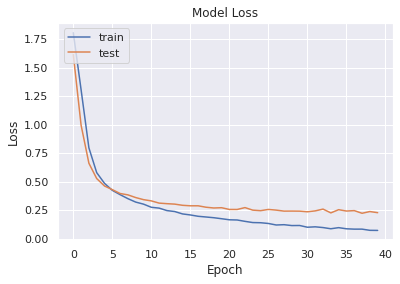

18/18 [==============================] - 0s 4ms/step - loss: 0.2277 - accuracy: 0.9482


In [15]:
# best batch size and epochs
best_params['batch_size'] = 32
best_params['epochs'] = 40

dropout_rate_params = (
    0.4,
    0.3,
    0.2,
    0.1
)

for param in dropout_rate_params:
    model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                     activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                     conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                     opt=best_params['opt'], dropout_rate=param)
    fit_save_results(model, batch_size=best_params['batch_size'], epochs=best_params['epochs'],
                    custom_model_name=f'droput_rate_{param}_model')

# best droput rate (0.2 slightly better accuracy, 0.4 better train, test curve match)
best_params['dropout_rate'] = 0.4

# Results

2022-05-27 12:29:30.762897: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-27 12:29:30.772000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-27 12:29:30.850531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 12:29:30.850834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.95GiB deviceMemoryBandwidth: 178.99GiB/s
2022-05-27 12:29:30.850900: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-27 12:29:30.893428: I tensorflow/stream_executor/platfor


Epoch 00001: val_accuracy improved from -inf to 0.59643, saving model to ../models/tess_hp_opt/final_model


2022-05-27 12:29:36.057519: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets

Epoch 00002: val_accuracy improved from 0.59643 to 0.72500, saving model to ../models/tess_hp_opt/final_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets

Epoch 00003: val_accuracy improved from 0.72500 to 0.76607, saving model to ../models/tess_hp_opt/final_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets

Epoch 00004: val_accuracy improved from 0.76607 to 0.81250, saving model to ../models/tess_hp_opt/final_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets

Epoch 00005: val_accuracy improved from 0.81250 to 0.82679, saving model to ../models/tess_hp_opt/final_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_model/assets

Epoch 00006: val_accuracy improved from 0.82679 to 0.86250, saving model to ../models/tess_hp_opt/final_model
INFO:tensorflow:Assets written to: ../models/tess_hp_opt/final_mo

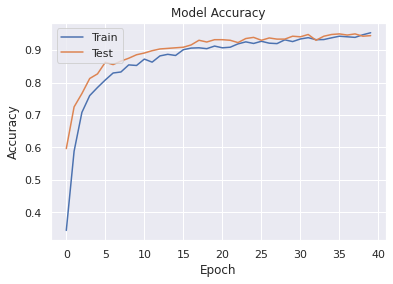

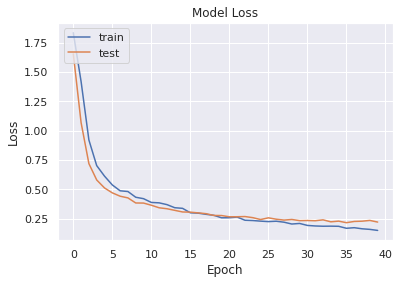

18/18 [==============================] - 0s 4ms/step - loss: 0.2225 - accuracy: 0.9446


In [10]:
best_params = {}
best_params['hlayers'] = 2
best_params['neurons'] = (173, 512, 512)
best_params['act_fun'] = 'relu'
best_params['out_act_fun'] = 'sigmoid'
best_params['kern_size'] = 5
best_params['pool_size'] = 7
best_params['opt'] = keras.optimizers.Adagrad(learning_rate=0.003)
best_params['batch_size'] = 32
best_params['epochs'] = 40
best_params['dropout_rate'] = 0.4

model = get_model(hidden_layers_count=best_params['hlayers'], layers_neurons_count=best_params['neurons'],
                 activation_function=best_params['act_fun'], output_activation_function=best_params['out_act_fun'],
                 conv_kernel_size=best_params['kern_size'], pooling_pool_size=best_params['pool_size'],
                 opt=best_params['opt'], dropout_rate=best_params['dropout_rate'])
fit_save_results(model, batch_size=best_params['batch_size'], epochs=best_params['epochs'],
                custom_model_name=f'final_model')

## accuracy and loss

In [11]:
# loss and accuracy percentage on test set
print("Loss of the model is - ", model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100, "%")

18/18 [==============================] - 0s 4ms/step - loss: 0.2225 - accuracy: 0.9446
Loss of the model is -  0.22250694036483765
18/18 [==============================] - 0s 4ms/step - loss: 0.2225 - accuracy: 0.9446
Accuracy of the model is -  94.46428418159485 %


In [12]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,happy,happy
2,neutral,neutral
3,surprised,surprised
4,happy,happy
5,sad,sad
6,sad,sad
7,fear,fear
8,surprised,surprised
9,surprised,happy


## confusion matrix

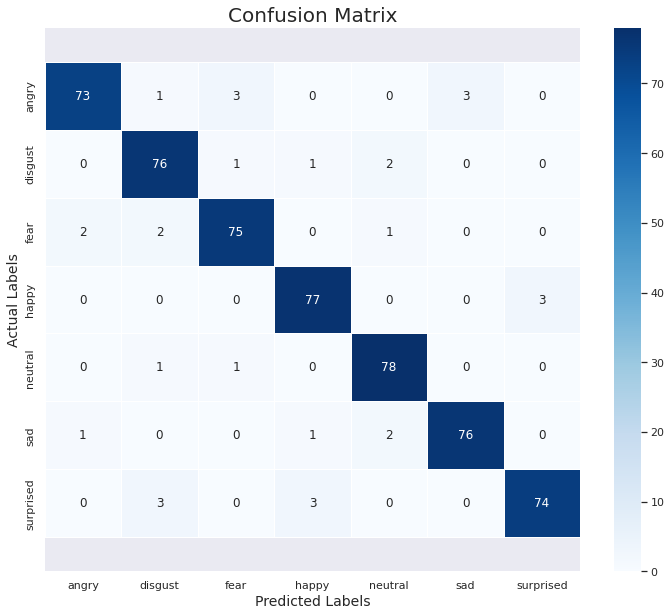

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_], columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [14]:
print(classification_report(actual, predictions, target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised']))

              precision    recall  f1-score   support

       angry       0.96      0.91      0.94        80
     disgust       0.92      0.95      0.93        80
        fear       0.94      0.94      0.94        80
       happy       0.94      0.96      0.95        80
     neutral       0.94      0.97      0.96        80
         sad       0.96      0.95      0.96        80
   surprised       0.96      0.93      0.94        80

    accuracy                           0.94       560
   macro avg       0.95      0.94      0.94       560
weighted avg       0.95      0.94      0.94       560

